In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")
    
import pickle

In [17]:
from src.dataloader import *
from src.models import *
from src.trainer import *
from src.utils import *
from src.evaluation import *
from src.regrid import *

In [4]:
DATADRIVE = '/home/jupyter/data/'

## Get mask

In [16]:
ds = xr.open_dataset(
    '/home/jupyter/data/hrrr/raw/total_precipitation/20180215_00.nc')

In [18]:
ds_regridded = regrid(ds, 4, lons=(235, 290), lats=(50, 20))[0]

Creating new regridder


/opt/conda/envs/ilan/lib/python3.9/site-packages/xesmf/frontend.py:555: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  ds_out = xr.apply_ufunc(


In [21]:
hrrr_mask = np.isfinite(ds_regridded).tp.isel(init_time=0, lead_time=0)

In [22]:
rq = xr.open_dataarray(f'{DATADRIVE}/mrms/4km/RadarQuality.nc')
mrms_mask = rq>-1
mrms_mask = mrms_mask.assign_coords({
    'lat': hrrr_mask.lat,
    'lon': hrrr_mask.lon
})

In [27]:
total_mask = mrms_mask * hrrr_mask

In [28]:
# total_mask = total_mask.isel(lat=slice(0, -6))

In [29]:
total_mask = total_mask.assign_coords({'lat': interp.lat.values, 'lon': interp.lon.values})

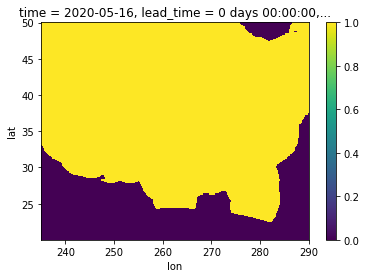

In [30]:
total_mask.plot()

## Load datasets

In [103]:
# # Using first few days of every month of 2020, eventually use all of 2020
ds_test = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2020-01', '2020-12'),
    scale=False,
    first_days=5,
)

/opt/conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


In [104]:
# # Using first few days of every month of 2020, eventually use all of 2020
ds_test_ens = TiggeMRMSDataset(
    tigge_dir=f'{DATADRIVE}/tigge/32km/',
    tigge_vars=['total_precipitation_ens10'],
    mrms_dir=f'{DATADRIVE}/mrms/4km/RadarOnly_QPE_06H/',
    rq_fn=f'{DATADRIVE}/mrms/4km/RadarQuality.nc',
#     const_fn='/datadrive/tigge/32km/constants.nc',
#     const_vars=['orog', 'lsm'],
    data_period=('2020-01', '2020-12'),
    scale=False,
    first_days=5,
)

/opt/conda/envs/ilan/lib/python3.9/site-packages/xarray/core/indexing.py:1379: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


Loading data


## MRMS

In [105]:
mrms = ds_test.mrms.rename({'time': 'valid_time'}).where(total_mask)

In [106]:
mrms = mrms.isel(valid_time=slice(1, None))

## Interpolation baseline

In [107]:
tigge = ds_test.tigge.isel(variable=0)
tigge_ens = ds_test_ens.tigge.isel(variable=0)

In [108]:
interp = tigge.interp_like(mrms, method='linear').where(total_mask)
interp_ens = tigge_ens.interp_like(mrms, method='linear').where(total_mask)

MemoryError: Unable to allocate 8.38 GiB for an array with shape (1376, 817500) and data type float64

In [ ]:
# To match HREF valid times
interp = interp.isel(valid_time=slice(1, None))
interp_ens = interp_ens.isel(valid_time=slice(1, None))

## HRRR baseline

In [ ]:
fn = f'{DATADRIVE}/hrrr/4km/total_precipitation/202001*.nc'
hrrr = xr.open_mfdataset(fn)

In [ ]:
hrrr = hrrr.tp.diff('lead_time').sel(lead_time=np.timedelta64(12, 'h'))

In [ ]:
hrrr['valid_time'] = hrrr.init_time + hrrr.lead_time
hrrr = hrrr.swap_dims({'init_time': 'valid_time'})

In [ ]:
hrrr = hrrr.assign_coords({'lat': interp.lat.values, 'lon': interp.lon.values})

In [ ]:
hrrr = hrrr.sel(valid_time=interp.valid_time).where(total_mask)

In [ ]:
hrrr.load()

## HREF baseline

In [ ]:
href = xr.open_mfdataset('/home/jupyter/data//href/4km/total_precipitation/202001*.nc')

In [ ]:
href = href.tp.diff('lead_time').sel(lead_time=np.timedelta64(12, 'h'))

In [ ]:
href['valid_time'] = href.init_time + href.lead_time
href = href.swap_dims({'init_time': 'valid_time'})

In [ ]:
href = href.assign_coords({'lat': interp.lat.values, 'lon': interp.lon.values})

In [ ]:
href = href.sel(valid_time=interp.valid_time).where(total_mask)

In [ ]:
href.load()

## Save intermediate arrays

In [ ]:
!mkdir -p tmp

In [ ]:
mrms.to_netcdf('tmp/mrms.nc')
interp.to_netcdf('tmp/interp.nc')
interp_ens.to_netcdf('tmp/interp_ens.nc')
hrrr.to_netcdf('tmp/hrrr.nc')
href.to_netcdf('tmp/href.nc')

## Compute scores

### Mean RMSE

In [34]:
xs.rmse(interp, mrms, dim=['lat', 'lon', 'valid_time'], skipna=True).values

array(1.27254262)

In [94]:
xs.rmse(hrrr, mrms, dim=['lat', 'lon', 'valid_time'], skipna=True).values

array(1.8412385, dtype=float32)

In [97]:
xs.rmse(interp_ens.mean('member'), mrms, dim=['lat', 'lon', 'valid_time'], skipna=True).values

array(1.12412284)

In [98]:
xs.rmse(href.mean('member'), mrms, dim=['lat', 'lon', 'valid_time'], skipna=True).values

array(1.4658927, dtype=float32)

### CRPS

In [101]:
xs.crps_ensemble(mrms, interp_ens, dim=['lat', 'lon', 'valid_time']).values

array(0.29236097)

In [102]:
xs.crps_ensemble(mrms, href, dim=['lat', 'lon', 'valid_time']).values

array(0.32329276)

### Thresholded RMSE

In [ ]:
def thresh_rmse(a, b, thresh):
    a_thresh = a > thresh
    b_thresh = b > thresh
    

In [7]:
rq = xr.open_dataarray('/datadrive_ssd/mrms/4km/RadarQuality.nc')
eval_mask = rq>-1
fn = "/datadrive_ssd/mrms/4km/RadarOnly_QPE_06H/RadarOnly_QPE_06H_00.00_20180101-000000.nc"
ds = xr.open_dataset(fn)
assert eval_mask.lat.shape ==ds.lat.shape
eval_mask['lat'] = ds.lat 
assert eval_mask.lon.shape ==ds.lon.shape
eval_mask['lon'] = ds.lon

In [8]:
mrms = ds_test.mrms.rename(
    {'time': 'valid_time'})
mrms = mrms.where(eval_mask)

In [9]:
tigge = ds_test.tigge.isel(variable=0)

In [10]:
interp = tigge.interp_like(mrms, method='linear')

In [11]:
mrms.chunk({'valid_time': 1})

<xarray.DataArray 'tp' (valid_time: 44, lat: 750, lon: 1376)>
dask.array<xarray-<this-array>, shape=(44, 750, 1376), dtype=float64, chunksize=(1, 750, 1376), chunktype=numpy.ndarray>
Coordinates:
  * valid_time  (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-12-0...
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0
    lead_time   timedelta64[ns] 12:00:00
    time        datetime64[ns] ...

In [12]:
interp

<xarray.DataArray (valid_time: 44, lat: 750, lon: 1376)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
    lead_time   timedelta64[ns] 12:00:00
    variable    <U2 'tp'
  * valid_time  (valid_time) datetime64[ns] 2020-01-01T12:00:00 ... 2020-12-0...
  * lat         (lat) float64 50.0 49.96 49.92 49.88 ... 20.16 20.12 20.08 20.04
  * lon         (lon) float64 235.0 235.0 235.1 235.1 ... 289.9 290.0 290.0

In [28]:
mrms_pert = mrms + np.random.normal(scale=1e-6, size=mrms.shape)
interp_pert = interp + np.random.normal(scale=1e-6, size=interp.shape)

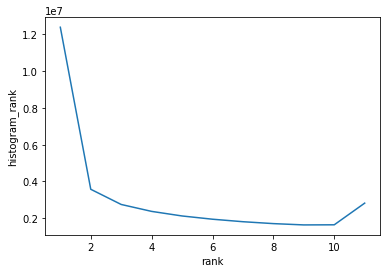

In [29]:
xs.rank_histogram(mrms_pert.chunk({'valid_time': 1}), interp_pert.chunk({'valid_time': 1})).compute().plot()

In [30]:
xs.crps_ensemble(mrms, interp)

<xarray.DataArray ()>
array(0.3749019)
Coordinates:
    time       datetime64[ns] 2020-05-16
    lead_time  timedelta64[ns] 12:00:00
    variable   <U2 'tp'

## HRRR

In [ ]:
!ls /datadrive_ssd/